# Chemical-Disease Relation (CDR) Tutorial

In this example, we'll be writing an application to extract *mentions of* **chemical-induced-disease relationships** from Pubmed abstracts, as per the [BioCreative CDR Challenge](http://www.biocreative.org/resources/corpora/biocreative-v-cdr-corpus/).  This tutorial will show off some of the more advanced features of Snorkel, so we'll assume you've followed the Intro tutorial.

Let's start by reloading from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()

In [3]:
from snorkel.models import Sentence, Document
docs = session.query(Document).all()

# Part III: Writing LFs

This tutorial features some more advanced LFs than the intro tutorial, with more focus on distant supervision and dependencies between LFs.

### Distant supervision approaches

We'll use the [Comparative Toxicogenomics Database](http://ctdbase.org/) (CTD) for distant supervision. The CTD lists chemical-condition entity pairs under three categories: therapy, marker, and unspecified. Therapy means the chemical treats the condition, marker means the chemical is typically present with the condition, and unspecified is...unspecified. We can write LFs based on these categories.

In [4]:
import bz2
from six.moves.cPickle import load

with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)

In [5]:
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0

In [6]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

### Text pattern approaches

Now we'll use some LF helpers to create LFs based on indicative text patterns. We came up with these rules by using the viewer to examine training candidates and noting frequent patterns.

In [7]:
import re
from snorkel.lf_helpers import (
    cross_context_get_tagged_text,
    cross_context_rule_regex_search_tagged_text,
    cross_context_rule_regex_search_btw_AB,
    cross_context_rule_regex_search_btw_BA,
    cross_context_rule_regex_search_before_A,
    cross_context_rule_regex_search_before_B,
    get_sentences
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', cross_context_get_tagged_text(c, session), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return cross_context_rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1, session)
def LF_d_induced_by_c_tight(c):
    return cross_context_rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1, session)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', cross_context_get_tagged_text(c, session), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', cross_context_get_tagged_text(c, session), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']

def LF_d_treat_c(c):
    return cross_context_rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1, session)
def LF_c_treat_d(c):
    return cross_context_rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1, session)
def LF_treat_d(c):
    return cross_context_rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1, session)
def LF_c_treat_d_wide(c):
    return cross_context_rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1, session)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in cross_context_get_tagged_text(c, session)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in cross_context_get_tagged_text(c, session)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return cross_context_rule_regex_search_before_B(c, 'improv.*', -1, session)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', cross_context_get_tagged_text(c, session), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return cross_context_rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1, session)

def LF_induced_other(c):
    return cross_context_rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1, session)

def LF_far_c_d(c):
    return cross_context_rule_regex_search_btw_AB(c, '.{100,5000}', -1, session)

def LF_far_d_c(c):
    return cross_context_rule_regex_search_btw_BA(c, '.{100,5000}', -1, session)

def LF_risk_d(c):
    return cross_context_rule_regex_search_before_B(c, 'risk of ', 1, session)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', cross_context_get_tagged_text(c, session), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), cross_context_get_tagged_text(c, session), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', cross_context_get_tagged_text(c, session), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', cross_context_get_tagged_text(c, session), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', cross_context_get_tagged_text(c, session), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, cross_context_get_tagged_text(c, session), flags=re.I) else 0

### Composite LFs

The following LFs take some of the strongest distant supervision and text pattern LFs, and combine them to form more specific LFs. These LFs introduce some obvious dependencies within the LF set, which we will model later.

In [8]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

### Rules based on context hierarchy

These last two rules will make use of the context hierarchy. The first checks if there is a chemical mention much closer to the candidate's disease mention than the candidate's chemical mention. The second does the analog for diseases.

In [9]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
#     if c.chemical.sentence.position == c.disease.sentence.position:
#         chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
#         dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
#         if dis_start < chem_start:
#             dist = chem_start - dis_end
#         else:
#             dist = dis_start - chem_end
#         # Try to find chemical closer than @dist/2 in either direction
#         sent = c.get_parent()
#         closest_other_chem = float('inf')
#         for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
#             et, cid = sent.entity_types[i], sent.entity_cids[i]
#             if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
#                 return -1
#         for i in range(max(0, dis_start - dist // 2), dis_start):
#             et, cid = sent.entity_types[i], sent.entity_cids[i]
#             if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
#                 return -1
#         return 0
#     else:
    if c.chemical.sentence.position == c.disease.sentence.position:
        chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
        dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()   
    elif c.chemical.sentence.position < c.disease.sentence.position:
        chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
        dis_start, dis_end = c.disease.get_word_start()+len(c.chemical.sentence.words), c.disease.get_word_end()+len(c.chemical.sentence.words)         
    else:
        chem_start, chem_end = c.chemical.get_word_start()+len(c.disease.sentence.words), c.chemical.get_word_end()+len(c.disease.sentence.words)
        dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()             

    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end

    sentence_lists = [(sent.entity_types, sent.entity_cids) for sent in get_sentences(c, session)]
    entity_types, entity_cids = [], []

    for (entity_type_list, entity_cid_list) in sentence_lists:
        entity_types.extend(entity_type_list)
        entity_cids.extend(entity_cid_list)

    closest_other_chem = float('inf')

    for i in range(dis_end, min(len(entity_cids), dis_end + dist // 2)):
        et, cid = entity_types[i], entity_cids[i]
        if et == 'Chemical' and cid != entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = entity_types[i], entity_cids[i]
        if et == 'Chemical' and cid != entity_cids[chem_start]:
            return -1
    return 0
        
                
        
        #TODO make one entity_types combined dictionary and iterate over it


def LF_closer_dis(c):
    # Get distance between chemical and disease
    
#     chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
#     dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
#     if dis_start < chem_start:
#         dist = chem_start - dis_end
#     else:
#         dist = dis_start - chem_end
#     # Try to find chemical disease than @dist/8 in either direction
#     sent = c.get_parent()
#     for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
#         et, cid = sent.entity_types[i], sent.entity_cids[i]
#         if et == 'Disease' and cid != sent.entity_cids[dis_start]:
#             return -1
#     for i in range(max(0, chem_start - dist // 8), chem_start):
#         et, cid = sent.entity_types[i], sent.entity_cids[i]
#         if et == 'Disease' and cid != sent.entity_cids[dis_start]:
#             return -1
#     return 0

    
    if c.chemical.sentence.position == c.disease.sentence.position:
        chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
        dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()   
    elif c.chemical.sentence.position < c.disease.sentence.position:
        chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
        dis_start, dis_end = c.disease.get_word_start()+len(c.chemical.sentence.words), c.disease.get_word_end()+len(c.chemical.sentence.words)         
    else:
        chem_start, chem_end = c.chemical.get_word_start()+len(c.disease.sentence.words), c.chemical.get_word_end()+len(c.disease.sentence.words)
        dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()             

    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
        
    # Try to find chemical disease than @dist/8 in either direction
    sentence_lists = [(sent.entity_types, sent.entity_cids) for sent in get_sentences(c, session)]
    entity_types, entity_cids = [], []

    for (entity_type_list, entity_cid_list) in sentence_lists:
        entity_types.extend(entity_type_list)
        entity_cids.extend(entity_cid_list)

    closest_other_chem = float('inf')
    
    for i in range(chem_end, min(len(entity_cids), chem_end + dist // 8)):
        et, cid = entity_types[i], entity_cids[i]
        if et == 'Disease' and cid != entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = entity_types[i], entity_cids[i]
        if et == 'Disease' and cid != entity_cids[dis_start]:
            return -1
    return 0

### Running the LFs on the training set

In [10]:
#     LF_closer_chem,
#     LF_closer_dis,
LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions,
]

In [11]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [12]:
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 7s, sys: 580 ms, total: 1min 7s
Wall time: 1min 9s


<12866x31 sparse matrix of type '<class 'numpy.int64'>'
	with 25108 stored elements in Compressed Sparse Row format>

In [13]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_c_cause_d,0,0.001710,0.001477,0.000700
LF_c_d,1,0.000000,0.000000,0.000000
LF_c_induced_d,2,0.000000,0.000000,0.000000
LF_c_treat_d,3,0.005674,0.005674,0.003886
LF_c_treat_d_wide,4,0.085808,0.085263,0.049044
LF_ctd_marker_c_d,5,0.000000,0.000000,0.000000
LF_ctd_marker_induce,6,0.000389,0.000389,0.000078
LF_ctd_therapy_treat,7,0.027981,0.027981,0.014612
LF_ctd_unspecified_treat,8,0.054329,0.054329,0.035287
LF_ctd_unspecified_induce,9,0.000233,0.000233,0.000078


# Part IV: Training the generative model

As mentioned above, we want to include the dependencies between our LFs when training the generative model. Snorkel makes it easy to do this! `DependencySelector` runs a fast structure learning algorithm over the matrix of LF outputs to identify a set of likely dependencies. We can see that these match up with our prior knowledge. For example, it identified a "reinforcing" dependency between `LF_c_induced_d` and `LF_ctd_marker_induce`. Recall that we constructed the latter using the former.

In [14]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

269

In [26]:
# from snorkel.lf_helpers import test_LF
# for lf in LFs:
#     print(lf.__name__)
#     tp, fp, tn, fn = test_LF(session, lf, split=1, annotator_name='gold')

Now we'll train the generative model, using the `deps` argument to account for the learned dependencies. We'll also model LF propensity here, unlike the intro tutorial. In addition to learning the accuracies of the LFs, this also learns their likelihood of labeling an example.

In [15]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [16]:
train_marginals = gen_model.marginals(L_train)

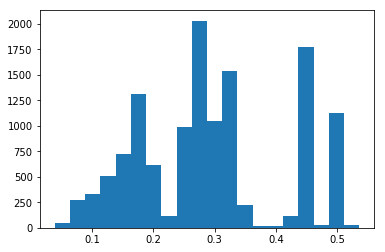

In [29]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [17]:
gen_model.learned_lf_stats()

/Users/felipe/Projects/snorkel/snorkel/learning/gen_learning.py:348: RuntimeWarning: invalid value encountered in double_scalars
  "Precision": tp / (tp + fp),


,Accuracy,Coverage,Precision,Recall
0,0.510000,0.0100,0.666667,0.000401
1,0.510000,0.0100,0.500000,0.000401
2,0.520000,0.0100,0.285714,0.000401
3,0.534091,0.0088,NaN,0.000000
4,0.614458,0.0332,0.647059,0.017628
5,0.505155,0.0097,0.500000,0.000401
6,0.505051,0.0099,0.000000,0.000000
7,0.581395,0.0086,0.833333,0.001002
8,0.584459,0.0296,0.609375,0.015625
9,0.509615,0.0104,0.333333,0.000200


In [18]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 12866 marginals


### Checking performance against development set labels

Finally, we'll run the labeler on the development set, load in some external labels, then evaluate the LF performance. The external labels are applied via a small script for convenience. It maps the document-level relation annotations found in the CDR file to mention-level labels. Note that these will not be perfect, although they are pretty good. If we wanted to keep iterating, we could use `snorkel.lf_helpers.test_LF` against the dev set, or look at some false positive and false negative candidates.

In [19]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

AnnotatorLabels created: 0


In [20]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<1566x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1566 stored elements in Compressed Sparse Row format>

In [21]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [22]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev, set_unlabeled_as_neg=False)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 0.983
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 18 | TN: 1072 | FN: 476



In [25]:
for metric in [tp, fp, tn, fn]:
    count = 0
    for sample in metric:
        if sample.chemical.sentence.position != sample.disease.sentence.position:
            count += 1
    print(str(count))

0
18
1072
476


In [74]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
for sample in fn:
    if sample.disease.sentence.position <= sample.chemical.sentence.position:
        first_mention = sample.disease
        second_mention = sample.chemical
    else:
        first_mention = sample.chemical
        second_mention = sample.disease
        
    first_sent = first_mention.sentence.text[:first_mention.char_start] + color.BOLD + first_mention.sentence.text[first_mention.char_start:first_mention.char_end+1].upper() + color.END + first_mention.sentence.text[first_mention.char_end+1:] 
    second_sent = second_mention.sentence.text[:second_mention.char_start] + color.BOLD + second_mention.sentence.text[second_mention.char_start:second_mention.char_end+1].upper() + color.END + second_mention.sentence.text[second_mention.char_end+1:]

    print(first_sent)
    print('|||')
    print(second_sent)
    print('#'*20)

Induction studies have further shown that while pretreatment of 3-methylcholanthrene (MC), an inducer of P4501A1/1A2, did not produce any significant effect in the incidence of lindane induced convulsions, pretreatment with phenobarbital (PB), an inducer of P450 2B1/2B2 or ethanol, an inducer of P450 2E1 catalysed reactions, significantly increased the incidence of lindane induced CONVULSIONS.
|||
Similarly, when the P450-mediated metabolism of lindane was blocked by cobalt chloride incidence of convulsions was increased in animals treated with LINDANE indicating that lindane per se or its metabolites formed by PB or ethanol inducible P450 isoenzymes are involved in its neurobehavioral toxicity.
####################
During dipyridamole-induced HYPEREMIA, 12 of the 16 dogs with a partial coronary stenosis had a visible area of hypoperfusion by contrast echocardiography.
|||
The four dogs without a perfusion defect had a stenosis that resulted in a mild (0% to 50%) reduction in DIPYRIDAM

In an attempt to overcome this problem, a clinical trial of CB 3717 administered with alkaline diuresis is under way.
|||
Preliminary results at 400 and 500 mg/m2 suggest that a reduction in NEPHROTOXICITY may have been achieved with only 1 instance of renal toxicity in 10 patients.
####################
In the present study, effects of nicotine on CATALEPSY induced by morphine in mice have been investigated.
|||
MORPHINE but not nicotine induced a dose-dependent catalepsy.
####################
Lithium was associated with a significantly higher incidence (p < 0.05) of tremor (18.4%) than quetiapine (5.6%); cerebellar tremor, which is a known adverse effect of lithium, may have contributed to the elevated rate of TREMOR in patients receiving lithium therapy.
|||
HALOPERIDOL induced a significantly higher incidence (p < 0.001) of akathisia (33.3% versus 5.9%), tremor (30.3% versus 7.8%), and extrapyramidal syndrome (35.4% versus 5.9%) than quetiapine.
####################
In an attempt to

Both patients and controls developed significantly stronger immediate HEADACHE on the GTN day than on the placebo day and the headache was significantly more pronounced in patients than in controls.
|||
There was no difference between the area under the CGRP curve (AUCCGRP) on GTN vs. placebo day in either patients (P=0.65) or controls (P=0.48).
####################
Intracerebroventricular injection of atropine, hexamethonium, and naloxone also decreased CATALEPSY induced by morphine plus nicotine.
|||
Intraperitoneal administration of atropine, but not intraperitoneal or intracerebroventricular injection of hexamethonium, decreased the effect of a single dose of MORPHINE.
####################
. MK-801 (0.1 mg/kg) administration attenuated the catalepsy and TREMOR induced by reserpine.
|||
Pretreatment with RESERPINE (1 mg/kg) 24 h before the observation test produced increases in vacuous chewing movements and tongue protrusion, as well as increases in tremor and catalepsy, whereas MK-

Quinidine HEPATITIS.

|||
Long-term administration of QUINIDINE was associated with persistent elevation of serum concentrations of SGOT, lactic acid dehydrogenase, and alkaline phosphatase.
####################
Calcitonin gene-related peptide levels during NITRIC OXIDE-induced headache in patients with chronic tension-type headache.

|||
It has been proposed that nitric oxide (NO) induced HEADACHE in primary headaches may be associated with release of calcitonin gene-related peptide (CGRP).
####################
It is likely that the hypersensitivity (eosinophilic) myocarditis was related to DOBUTAMINE infusion therapy.
|||
EOSINOPHILIC MYOCARDITIS has been reported with an incidence of 2.4% to 7.2% in explanted hearts and may be related to multidrug therapy.
####################
Amiodarone is an effective antiarrhythmic agent whose utility is limited by many side-effects, the most problematic being PNEUMONITIS.
|||
The pulmonary toxicity of AMIODARONE is thought to result from direct 

On the contrary, the SM-5887 treatment did not progress the grade of CARDIOMYOPATHY.
|||
In conclusion, SM-5887 does not have any potential of chronic cardiotoxicity and deteriorating effect on DOXORUBICIN-induced cardiotoxicity in dogs.
####################
HEPATONECROSIS AND CHOLANGITIS related to long-term phenobarbital therapy: an autopsy report of two patients.

|||
Phenobarbital (PB) has a reputation for safety, and it is commonly believed that PB-related increases in serum aminotransferase levels do not indicate or predict the development of significant chronic liver disease.
####################
Two elderly patients with a history of either cerebral vascular accident (CVA) or head trauma and no evidence of renal disease developed seizures while receiving maximum doses of IMIPENEM/CILASTATIN.
|||
Neither patient had reported previous SEIZURES or seizure-like activity nor was receiving anticonvulsant agents.
####################
Daily excretion of total protein, endogenous lysozy

A 34-year-old patient developed metastic ENDOMETRIAL CARCINOMA after Hodgkin disease in childhood.
|||
She had ovarian failure after abdominal irradiation and chemotherapy for Hodgkin disease, and received exogenous ESTROGENS, a treatment implicated in the development of endometrial cancer in menopausal women.
####################
The MTD of CIS-RA was 160 mg/m2/d.
|||
Dose-limiting toxicities in six of nine patients at 200 mg/m2/d included hypercalcemia (n = 3), RASH (n = 2), and anemia/thrombocytopenia/emesis/rash (n = 1).
####################
D-Penicillamine caused nephrotic syndrome in 1 patient and milder reversible PROTEINURIA in 3 other patients; none developed renal insufficiency.
|||
These data suggest that D-PENICILLAMINE may be effective in severe cases of localized scleroderma.
####################
PATIENTS AND METHODS: Two hundred ninety-seven patients with MBC and no prior chemotherapy for metastatic disease were randomized to receive either 60 mg/m(2) of Myocet (M) or co

A 59-year-old woman with ulcerative colitis developed red eyes, pleural effusion, eosinophilia and urinary abnormalities after restarting of SULPHASALAZINE treatment.
|||
Light microscopy of a kidney biopsy revealed SEGMENTAL NECROTIZING GLOMERULONEPHRITIS without deposition of immunoglobulin or complement.
####################
Quantitative drug levels in stimulant psychosis: relationship to symptom severity, catecholamines and HYPERKINESIA.

|||
To examine the relationship between quantitative stimulant drug levels, catecholamines, and psychotic symptoms, nineteen patients in a psychiatric emergency service with a diagnosis of amphetamine- or COCAINE-induced psychosis were interviewed, and plasma and urine were collected for quantitative assays of stimulant drug and catecholamine metabolite levels.
####################
Aggressive behaviors have been reported in patients who suffer from some PSYCHIATRIC DISORDERS, and are common in methamphetamine (METH) abusers.
|||
Herein, we report 

In [80]:
sample = fn.pop() 
        
from collections import deque

def shortest_path(graph, start, goal):
    queue = deque([(start, [start])])
    while queue:
        (vertex, path) = queue.popleft()
        for node in graph[vertex]['neighbors'] - set(path):
            if node == goal:
                chosen_path = path + [node]
                return [(graph[step]['word'], graph[step]['dep_type'])for step in chosen_path]
            else:
                queue.append((node, path + [node]))
                
def get_dep_path(c, session):

    span0 = c[0]
    span1 = c[1]
    
    if span0.sentence.position < span1.sentence.position:
        first_offset = span0.get_word_start() +1
        second_offset = span1.get_word_start()+len(span0.sentence._asdict()['words']) +1
    else:
        first_offset = span1.get_word_start() +1
        second_offset = span0.get_word_start()+len(span1.sentence._asdict()['words'])+1

    dep_heads, dep_labels, words = [], [], []
    sents = get_sentences(c, session)

    dep_heads.extend(sents[0]._asdict()['dep_parents'])
    past_root = dep_heads.index(0) + 1
    dep_labels.extend(sents[0]._asdict()['dep_labels'])
    words.extend(sents[0]._asdict()['words'])

    for i in range(1, len(sents)):

        temp_heads = []

        for j, head in enumerate(sents[i]._asdict()['dep_parents']):
            if head == 0:
                temp_heads.append(past_root)
                past_root = j + 1 + len(dep_heads)
            else:
                temp_heads.append(head+len(dep_heads))

        dep_heads.extend(temp_heads)
        dep_labels.extend(sents[i]._asdict()['dep_labels'])
        words.extend(sents[i]._asdict()['words'])


    dep_tree = {index: {'neighbors':set()} for index in range(1, len(dep_heads)+1)}

    for i, (parent, label, word) in enumerate(zip(dep_heads, dep_labels, words), 1):
        dep_tree[i]['dep_type'] = label
        dep_tree[i]['word'] = word
        if parent != 0:
            dep_tree[i]['neighbors'].add(parent)
        if parent != 0:
            dep_tree[parent]['neighbors'].add(i)
              
        
    return shortest_path(dep_tree, first_offset, second_offset)
    
    

In [81]:
if sample.disease.sentence.position <= sample.chemical.sentence.position:
    first_mention = sample.disease
    second_mention = sample.chemical
else:
    first_mention = sample.chemical
    second_mention = sample.disease

first_sent = first_mention.sentence.text[:first_mention.char_start] + color.BOLD + first_mention.sentence.text[first_mention.char_start:first_mention.char_end+1].upper() + color.END + first_mention.sentence.text[first_mention.char_end+1:] 
second_sent = second_mention.sentence.text[:second_mention.char_start] + color.BOLD + second_mention.sentence.text[second_mention.char_start:second_mention.char_end+1].upper() + color.END + second_mention.sentence.text[second_mention.char_end+1:]

print(first_sent)
print('|||')
print(second_sent)
print('#'*20)
get_dep_path(sample, session)

Induction studies have further shown that while pretreatment of 3-methylcholanthrene (MC), an inducer of P4501A1/1A2, did not produce any significant effect in the incidence of lindane induced convulsions, pretreatment with phenobarbital (PB), an inducer of P450 2B1/2B2 or ethanol, an inducer of P450 2E1 catalysed reactions, significantly increased the incidence of lindane induced CONVULSIONS.
|||
Similarly, when the P450-mediated metabolism of lindane was blocked by cobalt chloride incidence of convulsions was increased in animals treated with LINDANE indicating that lindane per se or its metabolites formed by PB or ethanol inducible P450 isoenzymes are involved in its neurobehavioral toxicity.
####################


[('convulsions', 'dobj'),
 ('induced', 'ccomp'),
 ('increased', 'conj'),
 ('induced', 'ccomp'),
 ('shown', 'ROOT'),
 ('increased', 'ROOT'),
 ('in', 'prep'),
 ('animals', 'pobj'),
 ('treated', 'acl'),
 ('with', 'prep'),
 ('lindane', 'pobj')]

In [27]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/Users/felipe/Projects/snorkel/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_c_cause_d,0,0.003831,0.003831,0.003831,2,4,0,0,0.333333,0.458333
LF_c_d,1,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.455904
LF_c_induced_d,2,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.457271
LF_c_treat_d,3,0.007024,0.007024,0.005747,0,0,6,5,0.454545,0.460725
LF_c_treat_d_wide,4,0.079821,0.079821,0.052363,0,0,47,78,0.624000,0.537234
LF_ctd_marker_c_d,5,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.461654
LF_ctd_marker_induce,6,0.000639,0.000639,0.000639,1,0,0,0,1.000000,0.458647
LF_ctd_therapy_treat,7,0.024266,0.024266,0.016603,0,0,14,24,0.631579,0.473515
LF_ctd_unspecified_treat,8,0.048531,0.048531,0.034483,0,0,29,47,0.618421,0.539295
LF_ctd_unspecified_induce,9,0.000639,0.000639,0.000639,1,0,0,0,1.000000,0.457399
